<a href="https://colab.research.google.com/github/weihaotey/dl-imperial-maths/blob/master/final_assignment_weihao_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Generative Adversarial Network

In this assignment, the goal is to generate random but distinctive and clear images mimicking from the fashion MNIST. There are many generative models that have been researched on in recent years, but here we will focus on the application of **Generative Adversarial Network (GAN)**.

The idea of GAN is to design two convolution networks:

1. _Discriminator :_  
Differentiate inputs from the real source (fashion MNIST) and from fake generated image from the _generator_ function.

2. _Generator :_   
Generates fake images (from normal distribution) that aimed to mimic images from the source.

Hence, the discriminator will be trained to be better at recognizing real image from the fake ones while the generator will be trained to produce images that are closer each step to the original source until they are undistinguishable. 

_Tensorflow_ is used to utilise the useful function defined in the package for the onvolutional neuron network in discriminator and generator functions.

Firstly, we need to include some necessary packages like tensorflow and numpy for the neuron network. Next, extract data from the idx files from fashion MNIST as numpy arrays. 


In [23]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import struct

def read_idx(filename):
    '''A function to read idx file format into numpy array'''
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
train_set = read_idx('train-images-idx3-ubyte (1)')
train_set = np.expand_dims(train_set, axis=3)
print(train_set.shape)
train_label = read_idx('train-labels-idx1-ubyte (1)')
train_label = np.expand_dims(train_label, axis=1)
print(train_label.shape)

test_set = read_idx('t10k-images-idx3-ubyte (1)')
test_set = np.expand_dims(test_set, axis=3)
print(test_set.shape)
test_label = read_idx('t10k-labels-idx1-ubyte (1)')
test_label = np.expand_dims(test_label, axis=1)
print(test_label.shape)
n_train = train_set.shape[0]
n_test = test_set.shape[0]

(60000, 28, 28, 1)
(60000, 1)
(10000, 28, 28, 1)
(10000, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [24]:
X = np.concatenate((train_set, test_set), axis=0) #mix both train set and test set
y = np.concatenate((train_label, test_label), axis=0).astype(np.int) #the label would not be used in this GAN model
print(X.shape)
print(y.shape)
      
#randomize the data
seed = 952
np.random.seed(seed)
np.random.shuffle(X)
np.random.seed(seed)
np.random.shuffle(y)

#y_vec to be transform to vectors with the label position as the digit 1 (one-hot vector)
y_vec = np.zeros((len(y), 10), dtype=np.float)
for i, label in enumerate(y):
    y_vec[i, y[i]] = 1.0

#normalize the tensor X 
data_fashion = [X / 255., y_vec]
print(y_vec.shape)

(70000, 28, 28, 1)
(70000, 1)
(70000, 10)


In [0]:
import math
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.contrib.slim as slim #for printing variables

#check if folder exists before writing into the file
def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

def display_vars():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

#for saving image every 300 steps
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imread(path, grayscale = False):
    if (grayscale):
        return scipy.misc.imread(path, flatten = True).astype(np.float)
    else:
        return scipy.misc.imread(path).astype(np.float)
      
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    return scipy.misc.imsave(path, image)

def center_crop(x, crop_h, crop_w, resize_h=64, resize_w=64):
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]
    j = int(round((h - crop_h)/2.))
    i = int(round((w - crop_w)/2.))
    return scipy.misc.imresize(x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w])

def transform(image, input_height, input_width, resize_height=64, resize_width=64, crop=True):
    if crop:
        cropped_image = center_crop(image, input_height, input_width, resize_height, resize_width)
    else:
        cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
    return np.array(cropped_image)/127.5 - 1.

def inverse_transform(images):
    return (images+1.)/2.


In [0]:
import math
import numpy as np 
import tensorflow as tf

from tensorflow.python.framework import ops

def bn(x, is_training, scope):
    return tf.contrib.layers.batch_norm(x,
                                        decay=0.9,
                                        updates_collections=None,
                                        epsilon=1e-5,
                                        scale=True,
                                        is_training=is_training,
                                        scope=scope)


def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
              initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))

        deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        return deconv

#Leak ReLU
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
        initializer=tf.constant_initializer(bias_start))
        
        return tf.matmul(input_, matrix) + bias

In [0]:
import os
import time
import tensorflow as tf
import numpy as np

class GAN(object):
    model_name = "GAN"     # name for checkpoint

    def __init__(self, sess, epoch, batch_size, z_dim, data_fashion, checkpoint_dir, result_dir, log_dir):
        self.sess = sess
        self.data_fashion = data_fashion
        self.checkpoint_dir = checkpoint_dir
        self.result_dir = result_dir
        self.log_dir = log_dir
        self.epoch = epoch
        self.batch_size = batch_size
        
        self.input_height = 28
        self.input_width = 28
        self.output_height = 28
        self.output_width = 28

        self.z_dim = z_dim         # dimension of noise-vector
        self.c_dim = 1

        # train parameter
        self.learning_rate = 0.0002
        self.beta1 = 0.5

        # number of generated images to be saved
        self.sample_num = 64  

        # load data
        self.data_X = data_fashion[0]
        self.data_y = data_fashion[1]

        # get number of batches for a single epoch
        self.num_batches = len(self.data_X) // self.batch_size
        
        
    def discriminator(self, x, is_training=True, reuse=False):
        # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
        # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
        with tf.variable_scope("discriminator", reuse=reuse):

            h = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
            h = lrelu(bn(conv2d(h, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
            h = tf.reshape(h, [self.batch_size, -1])
            h = lrelu(bn(linear(h, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn3'))
            out_logit = linear(h, 1, scope='d_fc4')
            out = tf.nn.sigmoid(out_logit)

            return out, out_logit, h

    def generator(self, z, is_training=True, reuse=False):
        # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
        # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
        with tf.variable_scope("generator", reuse=reuse):
            h = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
            h = tf.nn.relu(bn(linear(h, 128 * 7 * 7, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
            h = tf.reshape(h, [self.batch_size, 7, 7, 128])
            h = tf.nn.relu(
                bn(deconv2d(h, [self.batch_size, 14, 14, 64], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
                   scope='g_bn3'))

            out = tf.nn.sigmoid(deconv2d(h, [self.batch_size, 28, 28, 1], 4, 4, 2, 2, name='g_dc4'))

            return out

    def build_model(self):
        # some parameters
        image_dims = [self.input_height, self.input_width, self.c_dim]
        bs = self.batch_size

        """ Graph Input """
        # images
        self.inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')

        # noises
        self.z = tf.placeholder(tf.float32, [bs, self.z_dim], name='z')

        """ Loss Function """

        # output of D for real images
        D_real, D_real_logits, _ = self.discriminator(self.inputs, is_training=True, reuse=False)

        # output of D for fake images
        G = self.generator(self.z, is_training=True, reuse=False)
        D_fake, D_fake_logits, _ = self.discriminator(G, is_training=True, reuse=True)

        # get loss for discriminator
        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real)))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake)))

        self.d_loss = d_loss_real + d_loss_fake

        # get loss for generator
        self.g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake)))

        """ Training """
        # divide trainable variables into a group for D and a group for G
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if 'd_' in var.name]
        g_vars = [var for var in t_vars if 'g_' in var.name]

        # optimizers
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.d_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=self.beta1) \
                      .minimize(self.d_loss, var_list=d_vars)
            self.g_optim = tf.train.AdamOptimizer(self.learning_rate*5, beta1=self.beta1) \
                      .minimize(self.g_loss, var_list=g_vars)

        """" Testing """
        # for test
        self.fake_images = self.generator(self.z, is_training=False, reuse=True)

        """ Summary """
        d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
        d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
        d_loss_sum = tf.summary.scalar("d_loss", self.d_loss)
        g_loss_sum = tf.summary.scalar("g_loss", self.g_loss)

        # final summary operations
        self.g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
        self.d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

    def train(self):

        # initialize all variables
        tf.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.sample_z = np.random.uniform(-1, 1, size=(self.batch_size , self.z_dim))

        # saver to save model
        self.saver = tf.train.Saver()

        # summary writer
        self.writer = tf.summary.FileWriter(self.log_dir + '/' + self.model_name, self.sess.graph)

        # restore check-point if it exits
        could_load, checkpoint_counter = self.load(self.checkpoint_dir)
        if could_load:
            start_epoch = (int)(checkpoint_counter / self.num_batches)
            start_batch_id = checkpoint_counter - start_epoch * self.num_batches
            counter = checkpoint_counter
            print(" [*] Load SUCCESS")
        else:
            start_epoch = 0
            start_batch_id = 0
            counter = 1
            print(" [!] Load failed...")

        # loop for epoch
        start_time = time.time()
        dataplot = [] #for the plot of losses
        for epoch in range(start_epoch, self.epoch):

            # get batch data
            for idx in range(start_batch_id, self.num_batches
                #data for real images
                batch_images = self.data_X[idx*self.batch_size:(idx+1)*self.batch_size]
                           
                #data for fake images from uniform distribution
                batch_z = np.random.uniform(-1, 1, [self.batch_size, self.z_dim]).astype(np.float32)

                # update D network
                _, summary_str, d_loss = self.sess.run([self.d_optim, self.d_sum, self.d_loss],
                                               feed_dict={self.inputs: batch_images, self.z: batch_z})
                self.writer.add_summary(summary_str, counter)

                # update G network
                _, summary_str, g_loss = self.sess.run([self.g_optim, self.g_sum, self.g_loss], feed_dict={self.z: batch_z})
                self.writer.add_summary(summary_str, counter)

                # display training status
                print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                      % (epoch, idx, self.num_batches, time.time() - start_time, d_loss, g_loss))
                
                # track d_loss and g_loss for plot
                if np.mod(counter, 100):
                    dataplot.append([counter, d_loss, g_loss])

                # save training results for every 300 steps
                if np.mod(counter, 300) == 0:
                    samples = self.sess.run(self.fake_images, feed_dict={self.z: self.sample_z})
                    tot_num_samples = min(self.sample_num, self.batch_size)
                    manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                    manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                    save_images(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                                './' + check_folder(self.result_dir + '/' + self.model_dir) + '/' + self.model_name + '_train_{:02d}_{:04d}.png'.format(
                                    epoch, idx))
                counter += 1

            # After an epoch, start_batch_id is set to zero
            # non-zero value is only for the first epoch after loading pre-trained model
            start_batch_id = 0

            # save model
            self.save(self.checkpoint_dir, counter)

            # show temporal results
            self.visualize_results(epoch)

        # save model for final step
        self.save(self.checkpoint_dir, counter)
        dataplot = np.array(dataplot)
        return dataplot

    def visualize_results(self, epoch):
        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        """ random condition, random noise """

        z_sample = np.random.uniform(-1, 1, size=(self.batch_size, self.z_dim))

        samples = self.sess.run(self.fake_images, feed_dict={self.z: z_sample})

        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                    check_folder(self.result_dir + '/' + self.model_dir) + '/' + self.model_name + '_epoch%03d' % epoch + '_test_all_classes.png')

    @property
    def model_dir(self):
        return "{}_{}_{}_{}".format(
            self.model_name, 'fashion',
            self.batch_size, self.z_dim)

    def save(self, checkpoint_dir, step):
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        self.saver.save(self.sess,os.path.join(checkpoint_dir, self.model_name+'.model'), global_step=step)

    def load(self, checkpoint_dir):
        import re
        print(" [*] Reading checkpoints...")
        checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir, self.model_name)

        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            counter = int(next(re.finditer("(\d+)(?!.*\d)",ckpt_name)).group(0))
            print(" [*] Success to read {}".format(ckpt_name))
            return True, counter
        else:
            print(" [*] Failed to find a checkpoint")
            return False, 0

In [7]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    # declare instance for GAN
    epoch = 20
    batch_size = 64
    z_dim = 62
    checkpoint_dir = 'checkpoint'
    result_dir = 'result'
    log_dir = 'logs'
  

    gan = GAN(sess,
                            epoch=epoch,
                            batch_size=batch_size,
                            z_dim=z_dim,
                            data_fashion=data_fashion,
                            checkpoint_dir=checkpoint_dir,
                            result_dir=result_dir,
                            log_dir=log_dir)

    # build graph
    gan.build_model()

    # show network architecture
    display_vars()

    # launch the graph in a session
    dataplot = gan.train()
    print(" [*] Training finished!")

    # visualize learned generator
    gan.visualize_results(epoch-1)
    print(" [*] Testing finished!")

Epoch: [14] [ 771/1093] time: 12544.6037, d_loss: 0.77868652, g_loss: 1.87543881
Epoch: [14] [ 772/1093] time: 12545.3913, d_loss: 0.91186082, g_loss: 1.41648674
Epoch: [14] [ 773/1093] time: 12546.1708, d_loss: 0.84668118, g_loss: 1.46885216
Epoch: [14] [ 774/1093] time: 12546.9534, d_loss: 0.87822950, g_loss: 1.64860916
Epoch: [14] [ 775/1093] time: 12547.7376, d_loss: 0.94577575, g_loss: 1.66782594
Epoch: [14] [ 776/1093] time: 12548.5199, d_loss: 0.94575137, g_loss: 1.50180721
Epoch: [14] [ 777/1093] time: 12549.3093, d_loss: 0.83942819, g_loss: 1.51549506
Epoch: [14] [ 778/1093] time: 12550.0974, d_loss: 0.76528007, g_loss: 1.63351464
Epoch: [14] [ 779/1093] time: 12550.8766, d_loss: 0.84909672, g_loss: 1.75192475
Epoch: [14] [ 780/1093] time: 12551.6596, d_loss: 1.00163770, g_loss: 1.68007684
Epoch: [14] [ 781/1093] time: 12552.4404, d_loss: 1.06929827, g_loss: 1.50526571
Epoch: [14] [ 782/1093] time: 12553.2287, d_loss: 0.82431018, g_loss: 1.72353315
Epoch: [14] [ 783/1093] time

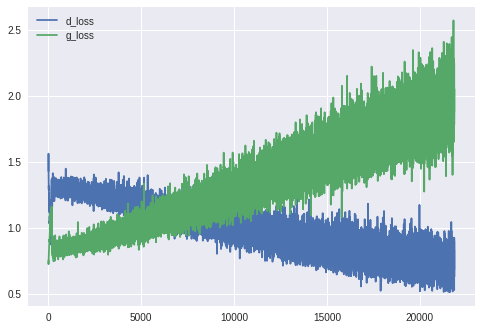

In [22]:
from matplotlib import pyplot as plt
iteration = dataplot[:,0]
d_loss = dataplot[:,1]
g_loss = dataplot[:,2]

d, = plt.plot(iteration, d_loss, label='d_loss')
g, = plt.plot(iteration, g_loss, label='g_loss')

plt.legend(handles=[d,g])
plt.savefig('loss.png',format='png')
plt.show()


